In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/sis2/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf

import os
import time
import datetime

import sis_helper as helper
from sis_helper import RGBProfile

from matplotlib import pyplot as plt
import numpy as np



In [ ]:
TILESIZE = 256

PATH_TRAIN = f'/content/drive/MyDrive/sis2/data/tfrecords{TILESIZE}'
PATH_VAL = f'/content/drive/MyDrive/sis2/data/tfrecords{TILESIZE}'

# The training set consist of n images
BUFFER_SIZE = 1077
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 10
LAMBDA = 100

#Set to exp of 2
IMG_WIDTH = TILESIZE
IMG_HEIGHT = TILESIZE

OUTPUT_CHANNELS = 3

In [ ]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
def normalize_numpy(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

def normalize_tensor(input_image, real_image):
    return tf.nn.l2_normalize(input_image), tf.nn.l2_normalize(real_image)

# def plot_feature_rgb(train_feature, ax=None):
#     train_feature_rgb = normalize_numpy(train_feature[:,:,0:3])
#     train_feature_rgb = train_feature_rgb[:,:,::-1]
#     if ax is None:
#         plt.figure(figsize=(7,7))
#         plt.imshow(train_feature_rgb)
#         plt.axis('off')
#         plt.show()
#     else:
#         ax.imshow(train_feature_rgb)

# def plot_agbm(train_agbm):
#     plt.figure(figsize=(7,7))
#     plt.imshow(train_agbm)
#     plt.axis('off')
#     plt.show()

# # Define the feature description
# train_tfrecord_description = {
#     'train_feature': tf.io.FixedLenFeature([256, 256, 11], tf.float32),
#     'train_agbm': tf.io.FixedLenFeature([256, 256], tf.float32),
# }

# # Define a function to parse the examples
# def parse_train_tfrecord(train_tfrecord):
#     example = tf.io.parse_single_example(train_tfrecord, train_tfrecord_description)
#     train_feature = example['train_feature']
#     train_agbm = example['train_agbm']
#     return train_feature, train_agbm



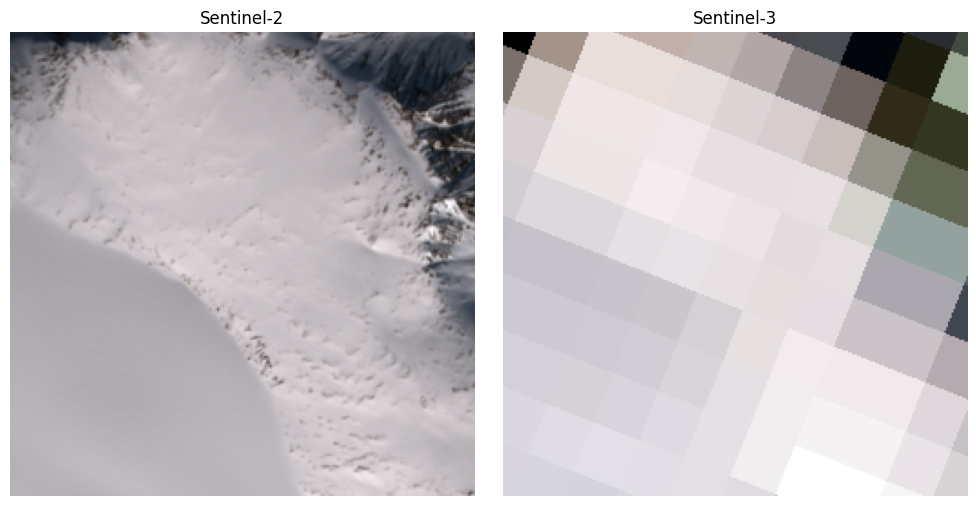

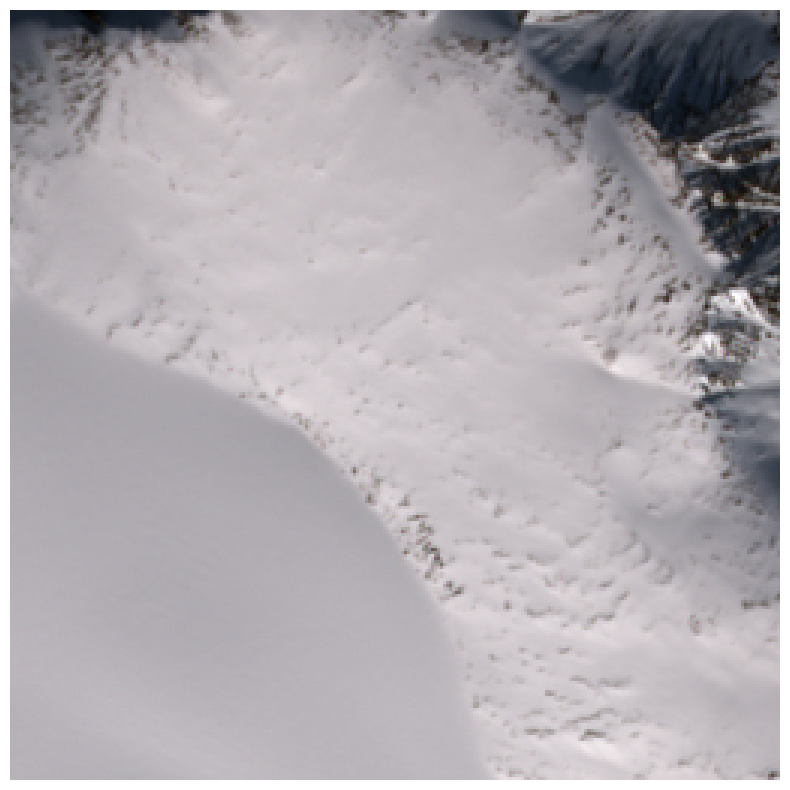

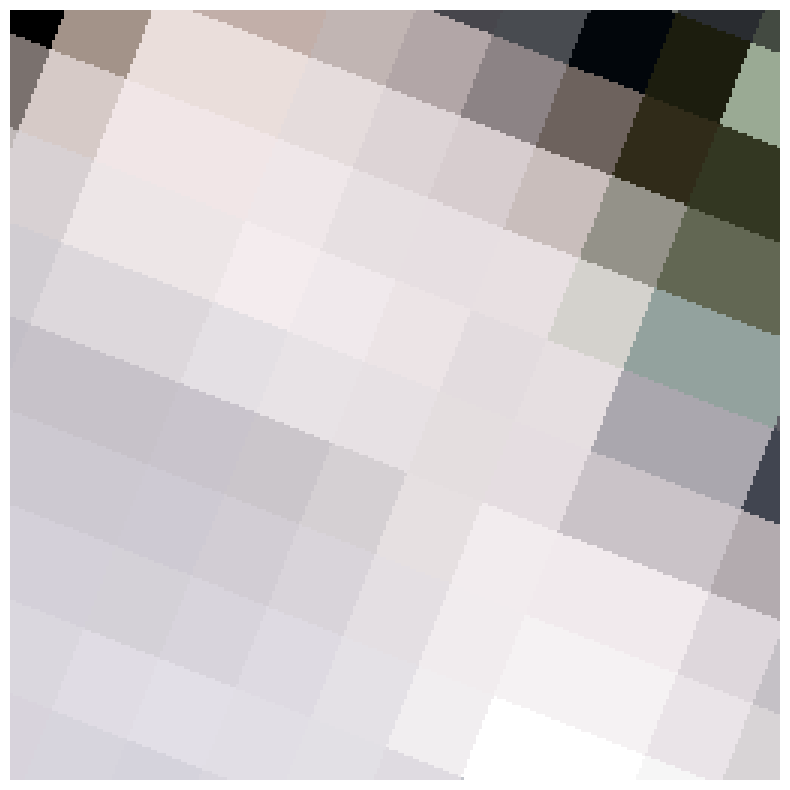

In [ ]:
# sample_dataset = tf.data.TFRecordDataset(os.path.join(PATH_VAL, '001_4012x2016.tfrecord'))
sample_dataset = tf.data.TFRecordDataset(os.path.join(PATH_VAL, '001_273x7842.tfrecord'))
for element in sample_dataset:
    helper.plot_tensor_sbs(element, TILESIZE)

    s2_tensor, s3_tensor = helper.parse_tfrecord(element, TILESIZE)
    helper.plot_tensor(s2_tensor, RGBProfile.S2)
    helper.plot_tensor(s3_tensor, RGBProfile.S3)


In [ ]:
def resize(image1, image2, height, width):
  image1 = tf.image.resize(image1, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image2 = tf.image.resize(image2, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return image1, image2

s2_tensor, s3_tensor = resize(s2_tensor, s3_tensor, IMG_HEIGHT, IMG_WIDTH)


In [ ]:
# def resize_one(input_image, height, width):
#   input_image = tf.image.resize(input_image, [height, width],
#                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

#   return input_image

In [ ]:
# def stretch(input_image, height, width):
#   input_image = tf.image.resize(input_image, [height, width],
#                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

#   return input_image

# s2_tensor = stretch(s2_tensor, TARGET_RESOLUTION, TARGET_RESOLUTION)
# s3_tensor = stretch(s3_tensor, TARGET_RESOLUTION, TARGET_RESOLUTION)

In [ ]:
def random_crop(input_image, real_image):
#   #TODO: Crop not to 3channels only!
#   stacked_image = tf.stack([input_image, real_image], axis=0)
#   cropped_image = tf.image.random_crop(
#       stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

#   return cropped_image[0], cropped_image[1]
    return resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)

In [ ]:
# def random_crop_one(input_image):
#   cropped_image = tf.image.random_crop(
#       input_image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

#   return cropped_image

In [ ]:
# # Normalizing the images to [-1, 1]
# def normalize(input_image, real_image):
#   # TODO: reflect which normalization is needed... divide by 1024????
#   input_image = (input_image / 127.5) - 1
#   real_image = (real_image / 127.5) - 1

#   return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, int(IMG_HEIGHT * 1.11), int(IMG_WIDTH * 1.11))

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  real_image = real_image[:,:,0]

  return input_image, real_image

In [ ]:
# def tensorize_input_images(images):
#   temp = []
#   for image in images:
#     temp.append(image[:,:,0])
#   tensors = tf.stack(temp, axis=2)
#   return tensors

In [ ]:
# plt.figure(figsize=(6, 6))
# for i in range(4):
#   rj_inp, rj_re = random_jitter(inp, re)
#   plt.subplot(2, 2, i + 1)
#   plt.imshow(rj_inp[:,:,0])
#   plt.axis('off')
# plt.show()

In [ ]:
def load_image_train(image_file):
  s2_image, s3_image = helper.parse_tfrecord(image_file, TILESIZE)
  s2_image, s3_image = resize(s2_image, s3_image, IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = random_jitter(s2_image, s3_image)
  s2_image, s3_image = normalize_tensor(s2_image, s3_image)

  return s2_image, s3_image

In [ ]:
def load_image_test(image_file):
  s2_image, s3_image = helper.parse_tfrecord(image_file, TILESIZE)
  s2_image, s3_image = resize(s2_image, s3_image, IMG_HEIGHT, IMG_WIDTH)
  s2_image, s3_image = normalize_tensor(s2_image, s3_image)

  # real_image = real_image[:,:,0]

  return s2_image, s3_image

# def load_image_test(image_file):
#   input_image, real_image = load(image_file)
#   input_images = imageise_input_image(input_image)
#   temp = []
#   for image in input_images:
#     temp.append(resize_one(image, IMG_HEIGHT, IMG_WIDTH))
#   input_image = tf.stack(temp, axis=2)[:,:,:,0]
#   real_image = imageise_real_image(real_image)
#   real_image = resize_one(real_image, IMG_HEIGHT, IMG_WIDTH)
#   real_image = real_image[:,:,0]
#
#   input_image, real_image = normalize(input_image, real_image)
#
#   return input_image, real_image

In [ ]:
train_file_list = [os.path.join(PATH_TRAIN, file) for file in os.listdir(PATH_TRAIN) if file.endswith('.tfrecord')]
train_dataset = tf.data.TFRecordDataset(train_file_list)

# train_dataset = tf.data.Dataset.list_files(str(f'{PATH_TRAIN}/*.tfrecords'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
test_file_list = [os.path.join(PATH_VAL, file) for file in os.listdir(PATH_VAL) if file.endswith('.tfrecord')]

try:
  # test_dataset = tf.data.Dataset.list_files(str(f'{PATH_VAL}/*.jpg'))
  test_dataset = tf.data.TFRecordDataset(test_file_list)
except tf.errors.InvalidArgumentError:
  # test_dataset = tf.data.Dataset.list_files(str(f'{PATH_TRAIN}/*.jpg'))
  test_dataset = tf.data.TFRecordDataset(train_file_list)
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(s3_tensor, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
up_model = upsample(21, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 21)


In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 21])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

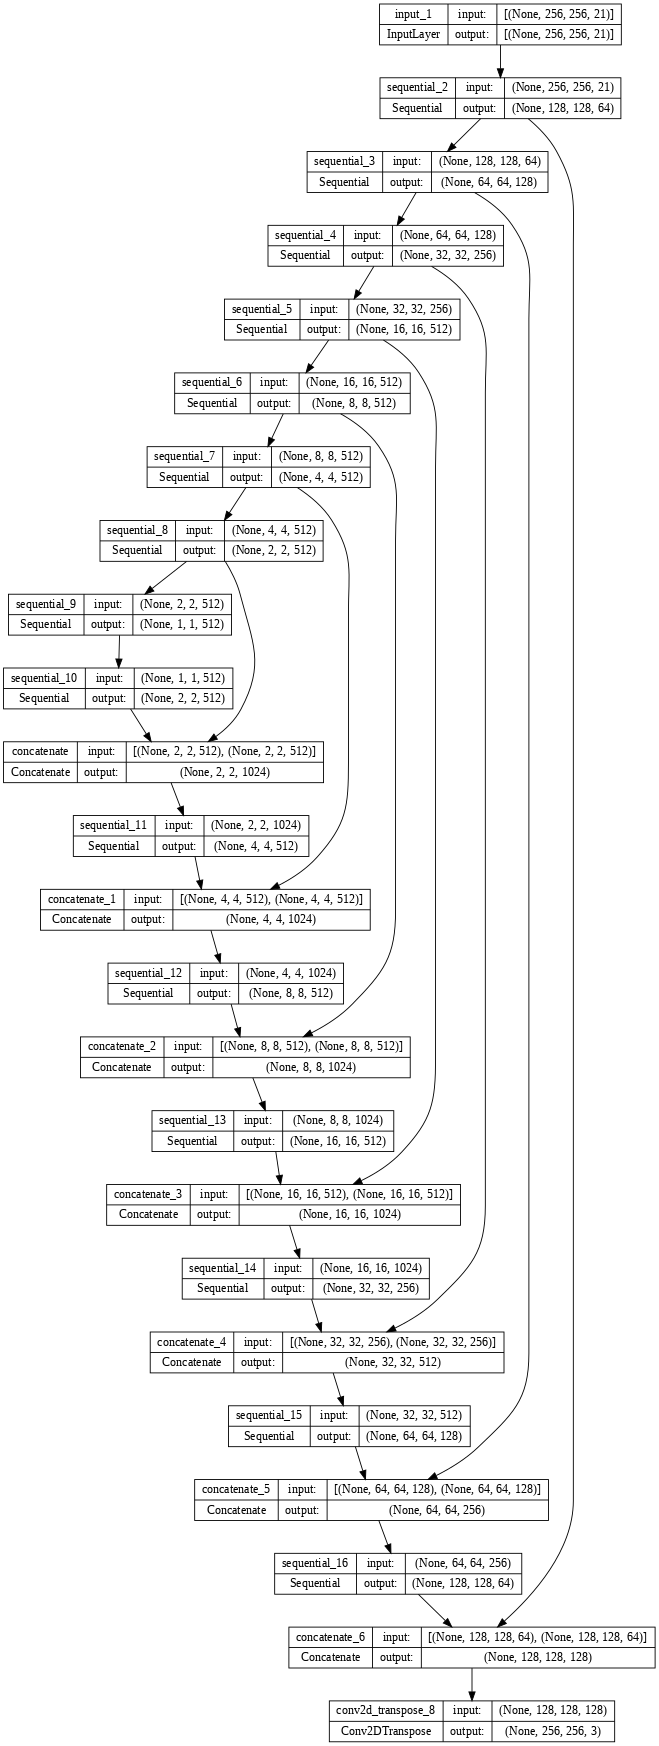

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

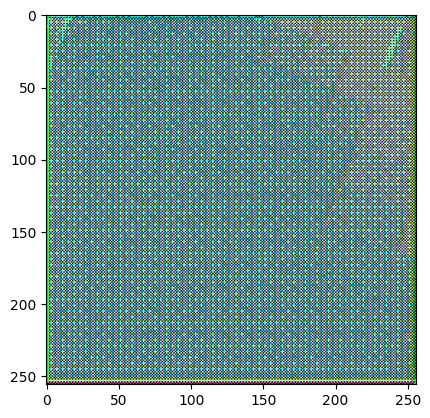

In [ ]:
gen_output = generator(s3_tensor[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  rmse_loss = tf.reduce_mean((target - gen_output) ** 2) ** 1/2

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss, rmse_loss

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 21], name='input_image')
  tar = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

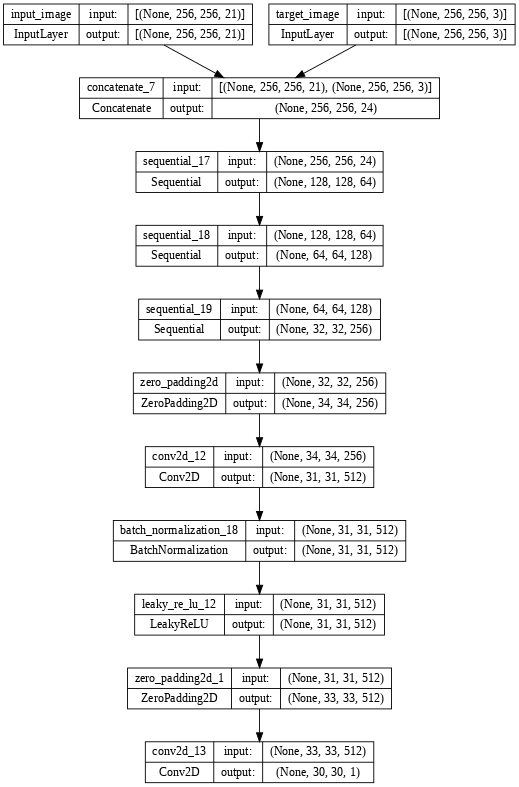

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

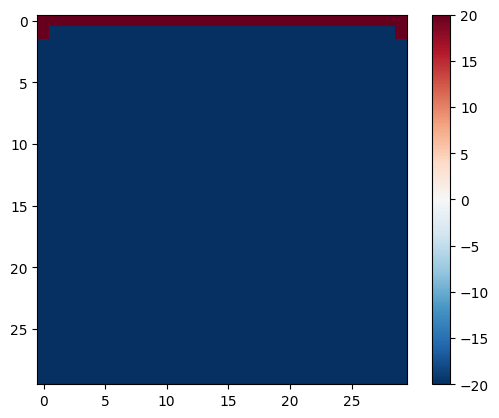

In [ ]:
disc_out = discriminator([s3_tensor[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)

  display_list = [test_input[0], tar[0], prediction[0]]

  plt.figure(figsize=(20,15))
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

  # plotting Input images
  # plot_feature_rgb(display_list[0].numpy(), ax1)

  red_band = helper.normalize_numpy(display_list[0][:,:,16].numpy())
  green_band = helper.normalize_numpy(display_list[0][:,:,5].numpy())
  blue_band = helper.normalize_numpy(display_list[0][:,:,2].numpy())
  rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)
  ax1.imshow(rgb_image)
  ax1.set_title('Input Image')
  ax1.axis('off')


  red_band = helper.normalize_numpy(display_list[1][:,:,2].numpy())
  green_band = helper.normalize_numpy(display_list[1][:,:,1].numpy())
  blue_band = helper.normalize_numpy(display_list[1][:,:,0].numpy())
  rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)
  ax2.imshow(rgb_image)
  ax2.set_title('Ground Truth')
  ax2.axis('off')

  red_band = helper.normalize_numpy(display_list[2][:,:,2].numpy())
  green_band = helper.normalize_numpy(display_list[2][:,:,1].numpy())
  blue_band = helper.normalize_numpy(display_list[2][:,:,0].numpy())
  rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)
  ax3.imshow(rgb_image)
  ax3.set_title('Predicted Image')
  ax3.axis('off')

  # automatically adjust padding horizontally
  # as well as vertically.
  plt.tight_layout()
  # display plot
  plt.show()


<Figure size 2000x1500 with 0 Axes>

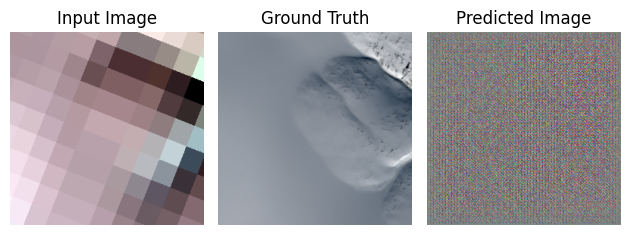

<Figure size 2000x1500 with 0 Axes>

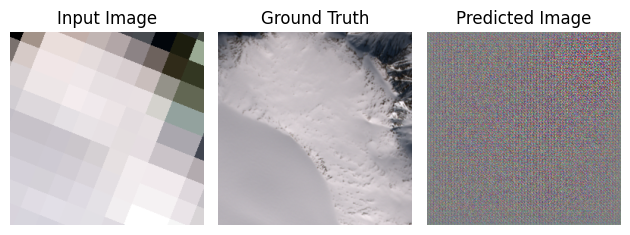

<Figure size 2000x1500 with 0 Axes>

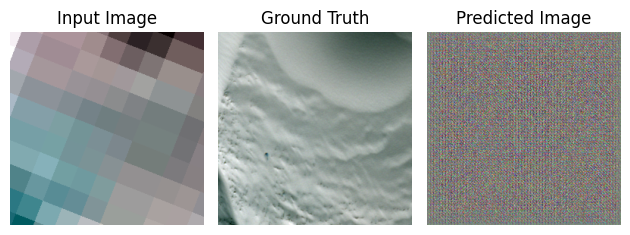

<Figure size 2000x1500 with 0 Axes>

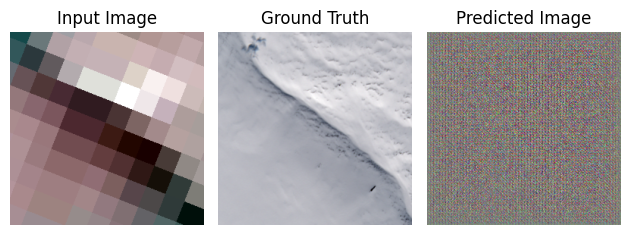

In [ ]:
for example_target, example_input in test_dataset.take(4):
  generate_images(generator, example_input, example_target)

In [ ]:
log_dir="logs_5e/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss, gen_rmse_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('gen_rmse_loss', gen_rmse_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
def fit(train_ds, test_ds, steps):
  example_target, example_input = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (target, input_image) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      # display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)

    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

<Figure size 2000x1500 with 0 Axes>

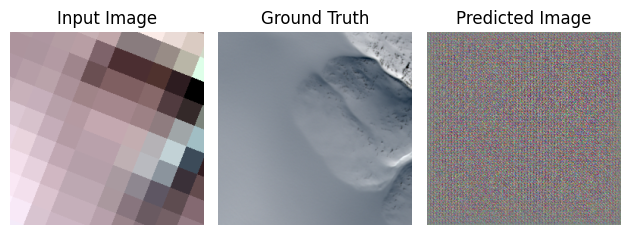

Step: 0k
....................................................................................................Time taken for 1000 steps: 2034.00 sec



<Figure size 2000x1500 with 0 Axes>

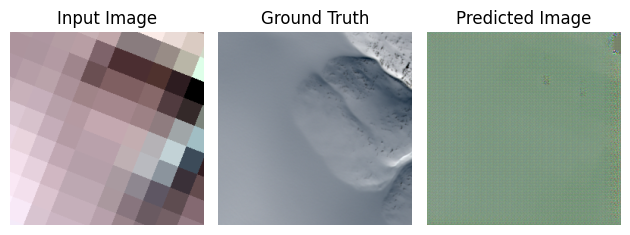

Step: 1k
............................................................................

In [ ]:
fit(train_dataset, test_dataset, steps=40000)

In [ ]:
log_dir="logs_5e/"
!tensorboard dev upload --logdir {log_dir}